# LSTM and GRU RNNs on the Penn Tree Bank Dataset

### This Notebook includes a reimplementation of the "small" **LSTM** model as described in "Recurrent Neural Network Regularization", by Zaremba et al. (https://arxiv.org/abs/1409.2329). The notebook goes further than the paper by applying the **GRU (Gated Recurrent Units)** model to the same data.


###Loading the data

In [1]:
!wget http://www.fit.vutbr.cz/~imikolov/rnnlm/simple-examples.tgz

!tar -xvzf simple-examples.tgz

--2024-09-25 19:30:41--  http://www.fit.vutbr.cz/~imikolov/rnnlm/simple-examples.tgz
Resolving www.fit.vutbr.cz (www.fit.vutbr.cz)... 147.229.9.23, 2001:67c:1220:809::93e5:917
Connecting to www.fit.vutbr.cz (www.fit.vutbr.cz)|147.229.9.23|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://www.fit.vut.cz/~imikolov/rnnlm/simple-examples.tgz [following]
--2024-09-25 19:30:42--  https://www.fit.vut.cz/~imikolov/rnnlm/simple-examples.tgz
Resolving www.fit.vut.cz (www.fit.vut.cz)... 147.229.9.65, 2001:67c:1220:809::93e5:941
Connecting to www.fit.vut.cz (www.fit.vut.cz)|147.229.9.65|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://www.fit.vut.cz/person/imikolov/public/rnnlm/simple-examples.tgz [following]
--2024-09-25 19:30:43--  https://www.fit.vut.cz/person/imikolov/public/rnnlm/simple-examples.tgz
Reusing existing connection to www.fit.vut.cz:443.
HTTP request sent, awaiting response... 200 OK


Main imports

In [27]:
import torch
import torch.nn as nn
import torch.optim as optim
import math
from collections import Counter
from itertools import chain
import numpy as np

In [28]:
def load_data(file):
    with open(file, 'r') as f:
        text = f.read().replace("\n", " <eos> ").strip()
    return text.split()

train_file = 'simple-examples/data/ptb.train.txt'
valid_file = 'simple-examples/data/ptb.valid.txt'
test_file = 'simple-examples/data/ptb.test.txt'

train_data = load_data(train_file)
valid_data = load_data(valid_file)
test_data = load_data(test_file)

Starting Parameters

In [29]:
BATCH_SIZE = 20
SEQ_LENGTH = 20
LAYERS = 2
RNN_SIZE = 200
DROPOUT = 0
INIT_WEIGHT = 0.1
LR = 2
VOCAB_SIZE = 10000
MAX_EPOCH = 13
DECAY_EPOCH = 7
MAX_GRAD_NORM = 5

Building the Vocab (A mapping of unique integer indices)

In [30]:
def build_vocab(data, vocab_size=VOCAB_SIZE):
    counter = Counter(data)
    most_common = counter.most_common(vocab_size - 1)
    vocab = {word: i+1 for i, (word, _) in enumerate(most_common)}
    vocab["<unk>"] = 0
    return vocab

vocab = build_vocab(train_data)

Setting Device to GPU

In [31]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Converting words to PyTorch tensor of word indices

In [32]:
def text_to_tensor(data, vocab):
    return torch.tensor([vocab.get(word, vocab["<unk>"]) for word in data], dtype=torch.long)

train_data = text_to_tensor(train_data, vocab)
valid_data = text_to_tensor(valid_data, vocab)
test_data = text_to_tensor(test_data, vocab)

## LSTM Model (Pytorch nn.Module)




In [34]:
class LSTMModel(nn.Module):
    def __init__(self, vocab_size, rnn_size, layers, dropout):
        super(LSTMModel, self).__init__()
        self.drop = nn.Dropout(dropout)
        self.encoder = nn.Embedding(vocab_size, rnn_size)
        self.lstm = nn.LSTM(rnn_size, rnn_size, layers, dropout=dropout)
        self.decoder = nn.Linear(rnn_size, vocab_size)
        self.init_weights()
        self.rnn_size = rnn_size
        self.layers = layers

    def init_weights(self):
        initrange = INIT_WEIGHT
        self.encoder.weight.data.uniform_(-initrange, initrange)
        self.decoder.weight.data.uniform_(-initrange, initrange)
        self.decoder.bias.data.zero_()

    def forward(self, input, hidden):
        emb = self.drop(self.encoder(input))
        output, hidden = self.lstm(emb, hidden)
        output = self.drop(output)
        decoded = self.decoder(output.view(output.size(0) * output.size(1), output.size(2)))
        return decoded.view(output.size(0), output.size(1), decoded.size(1)), hidden

    def init_hidden(self, bsize):
        weight = next(self.parameters())
        return (weight.new_zeros(LAYERS, bsize, RNN_SIZE),
                weight.new_zeros(LAYERS, bsize, RNN_SIZE))

Detaching hidden states from history by creating new tensors

In [35]:
def detach_hidden(h):
    if isinstance(h, torch.Tensor):
        return h.detach()
    else:
        return tuple(detach_hidden(v) for v in h)

Function to evaluate a trained RNN model, returns avg. loss

In [36]:
def evaluate(model, data_source, criterion, seq_length):
    model.eval()
    total_loss = 0.
    ntokens = VOCAB_SIZE
    chunk_size = len(data_source) // BATCH_SIZE

    hidden = model.init_hidden(BATCH_SIZE)

    with torch.no_grad():
        for j in range(0, chunk_size - seq_length, seq_length):
            inputs = torch.stack([torch.LongTensor(data_source[i * chunk_size + j: i * chunk_size + j + seq_length])
                                  for i in range(BATCH_SIZE)], dim=1).to(device)
            targets = torch.stack([torch.LongTensor(data_source[i * chunk_size + j + 1: i * chunk_size + j + seq_length + 1])
                                   for i in range(BATCH_SIZE)], dim=1).to(device)

            output, hidden = model(inputs, hidden)
            hidden = detach_hidden(hidden)
            loss = criterion(output.view(-1, ntokens), targets.view(-1))
            total_loss += loss.item()

    return total_loss / (chunk_size // seq_length)

Function to train an RNN model. This includes gradient clipping to prevent exploding gradients. Returns avg. loss

In [37]:
def train(model, train_data, optimizer, criterion, seq_length):
    model.train()
    total_loss = 0.
    ntokens = VOCAB_SIZE
    chunk_size = len(train_data) // BATCH_SIZE

    hidden = model.init_hidden(BATCH_SIZE)

    for j in range(0, chunk_size - seq_length, seq_length):
        inputs = torch.stack([torch.LongTensor(train_data[i * chunk_size + j: i * chunk_size + j + seq_length])
                              for i in range(BATCH_SIZE)], dim=1).to(device)
        targets = torch.stack([torch.LongTensor(train_data[i * chunk_size + j + 1: i * chunk_size + j + seq_length + 1])
                               for i in range(BATCH_SIZE)], dim=1).to(device)

        hidden = detach_hidden(hidden)
        model.zero_grad()

        output, hidden = model(inputs, hidden)
        loss = criterion(output.view(-1, ntokens), targets.view(-1))

        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), MAX_GRAD_NORM)

        optimizer.step()

        total_loss += loss.item()

    return total_loss / (chunk_size // seq_length)

Generating Plots

In [38]:
from matplotlib import pyplot as plt
def plot_perplexities(train_perplexities, test_perplexities, title):
    plt.figure(figsize=(10, 5))
    plt.plot(range(1, MAX_EPOCH + 1), train_perplexities, label='Train Perplexity')
    plt.plot(range(1, MAX_EPOCH + 1), test_perplexities, label='Test Perplexity')
    plt.title(title)
    plt.xlabel('Epoch')
    plt.ylabel('Perplexity')
    plt.legend()
    plt.grid()
    plt.show()

Function to train and evaluate LSTM RNN over "MAX_MAX_EPOCH" epochs. This handles the word-level perplexity calculations

In [47]:
def train_and_evaluate(model, train_data, valid_data, test_data, optimizer, criterion, SEQ_LENGTH, MAX__EPOCH, DECAY_EPOCH, save_path, title):
    train_perplexities = []
    val_perplexities = []
    test_perplexities = []

    for epoch in range(MAX_EPOCH):
        train_loss = train(model, train_data, optimizer, criterion, SEQ_LENGTH)
        val_loss = evaluate(model, valid_data, criterion, SEQ_LENGTH)
        test_loss = evaluate(model, test_data, criterion, SEQ_LENGTH)

        curr_train_perplexity = math.exp(train_loss)
        curr_val_perplexity = math.exp(val_loss)
        curr_test_perplexity = math.exp(test_loss)

        train_perplexities.append(curr_train_perplexity)
        val_perplexities.append(curr_val_perplexity)
        test_perplexities.append(curr_test_perplexity)

        print(f'Epoch {epoch+1}, Train Perplexity: {curr_train_perplexity:.4f}, Val Perplexity: {curr_val_perplexity:.4f}, Test Perplexity: {curr_test_perplexity:.4f}')

        ### Learning rate decay
        if epoch + 1 >= DECAY_EPOCH:
            for param_group in optimizer.param_groups:
                param_group['lr'] /= 2
            print(f'Learning rate reduced to: {optimizer.param_groups[0]["lr"]:.4f}')

    ### Saving model
    torch.save(model.state_dict(), save_path)
    print(f"Model saved to {save_path}")

    plot_perplexities(train_perplexities, test_perplexities, title)

    return train_perplexities[-1], val_perplexities[-1], test_perplexities[-1]

#LSTM (no dropout) Evaluation

#### Evaluated on word-level perplexity as a function of training epoch

##### PARAMETERS


1.   **Dropout = 0.00 %**
2.   **Learning Rate = 3**
3.   **Learning Rate Decay Epoch = 7**
4.   **Number of Epochs = 13**



Epoch 1, Train Perplexity: 497.7511, Val Perplexity: 304.6621, Test Perplexity: 296.6659
Epoch 2, Train Perplexity: 231.1572, Val Perplexity: 211.5719, Test Perplexity: 205.1579
Epoch 3, Train Perplexity: 167.2147, Val Perplexity: 174.3294, Test Perplexity: 168.9778
Epoch 4, Train Perplexity: 135.3924, Val Perplexity: 155.6586, Test Perplexity: 151.7177
Epoch 5, Train Perplexity: 115.6805, Val Perplexity: 145.6414, Test Perplexity: 142.1864
Epoch 6, Train Perplexity: 101.9796, Val Perplexity: 139.1925, Test Perplexity: 135.7547
Epoch 7, Train Perplexity: 91.6944, Val Perplexity: 135.8568, Test Perplexity: 132.7563
Learning rate reduced to: 1.5000
Epoch 8, Train Perplexity: 78.5371, Val Perplexity: 129.3439, Test Perplexity: 125.9327
Learning rate reduced to: 0.7500
Epoch 9, Train Perplexity: 71.3349, Val Perplexity: 125.7259, Test Perplexity: 122.5193
Learning rate reduced to: 0.3750
Epoch 10, Train Perplexity: 67.6657, Val Perplexity: 123.7531, Test Perplexity: 120.7417
Learning rate 

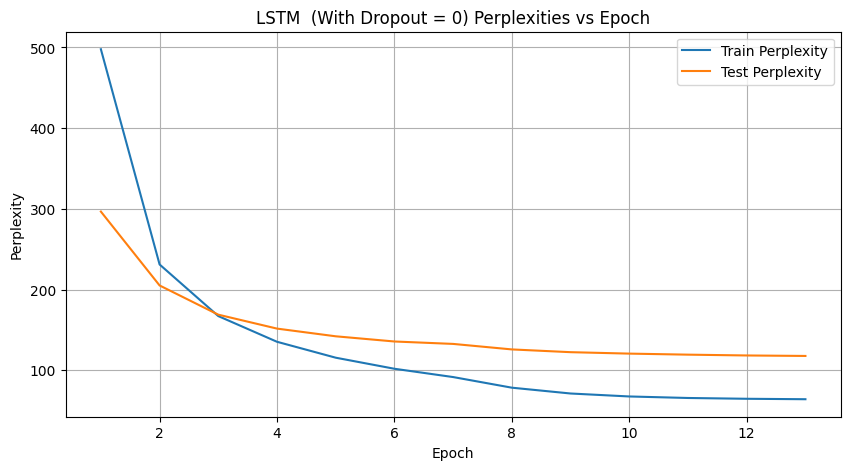

Final Train Perplexity: 64.2526
Final Test Perplexity: 117.8531
Final Validation Perplexity: 121.2307


In [48]:
DROPOUT = 0
LR = 3
DECAY_EPOCH = 7
MAX_EPOCH = 13

model = LSTMModel(VOCAB_SIZE, RNN_SIZE, LAYERS, DROPOUT).to(device)
optimizer = optim.SGD(model.parameters(), lr=LR)
criterion = nn.CrossEntropyLoss()

train_perplexity_lstm, val_perplexity_lstm, test_perplexity_lstm = train_and_evaluate(
    model, train_data, valid_data, test_data, optimizer, criterion,
    SEQ_LENGTH, MAX_EPOCH, DECAY_EPOCH, "lstm_model.pth", "LSTM  (With Dropout = " + str(DROPOUT) + ") Perplexities vs Epoch"
)

print(f"Final Train Perplexity: {train_perplexity_lstm:.4f}")
print(f"Final Test Perplexity: {test_perplexity_lstm:.4f}")
print(f"Final Validation Perplexity: {val_perplexity_lstm:.4f}")

### OPTIONAL: **Infer With Trained Model** (example)

In [ ]:
model = LSTMModel(VOCAB_SIZE, RNN_SIZE, LAYERS, DROPOUT).to(device)

model.load_state_dict(torch.load("lstm_model.pth"))
model.eval()

def predict(model, data):
    model.eval()
    with torch.no_grad():
        output = model(data)
    return output


Example inference


```
test_input = torch.tensor([your_test_sequence], dtype=torch.long)  # Replace with actual test data
output = predict(model, test_input)
print(f"Inference result: {output}")
```



# LSTM *With Dropout* Evaluation


#### Evaluated on word-level perplexity as a function of training epoch


##### PARAMETERS

1.   **Dropout = 0.33 %**
2.   **Learning Rate = 6**
3.   **Learning Rate Decay Epoch = 20**
4.   **Number of Epochs = 30**

Epoch 1, Train Perplexity: 500.9510, Val Perplexity: 297.6675, Test Perplexity: 289.9617
Epoch 2, Train Perplexity: 268.0974, Val Perplexity: 215.7412, Test Perplexity: 209.7615
Epoch 3, Train Perplexity: 209.9929, Val Perplexity: 184.0538, Test Perplexity: 178.5235
Epoch 4, Train Perplexity: 180.2268, Val Perplexity: 163.8926, Test Perplexity: 159.1396
Epoch 5, Train Perplexity: 160.4000, Val Perplexity: 151.5055, Test Perplexity: 146.8817
Epoch 6, Train Perplexity: 146.4389, Val Perplexity: 140.3616, Test Perplexity: 136.2417
Epoch 7, Train Perplexity: 135.7467, Val Perplexity: 133.9328, Test Perplexity: 130.1749
Epoch 8, Train Perplexity: 127.5442, Val Perplexity: 128.0285, Test Perplexity: 124.8522
Epoch 9, Train Perplexity: 120.9557, Val Perplexity: 123.6051, Test Perplexity: 119.9993
Epoch 10, Train Perplexity: 115.4793, Val Perplexity: 120.4496, Test Perplexity: 116.8213
Epoch 11, Train Perplexity: 110.6153, Val Perplexity: 117.7666, Test Perplexity: 114.0953
Epoch 12, Train Per

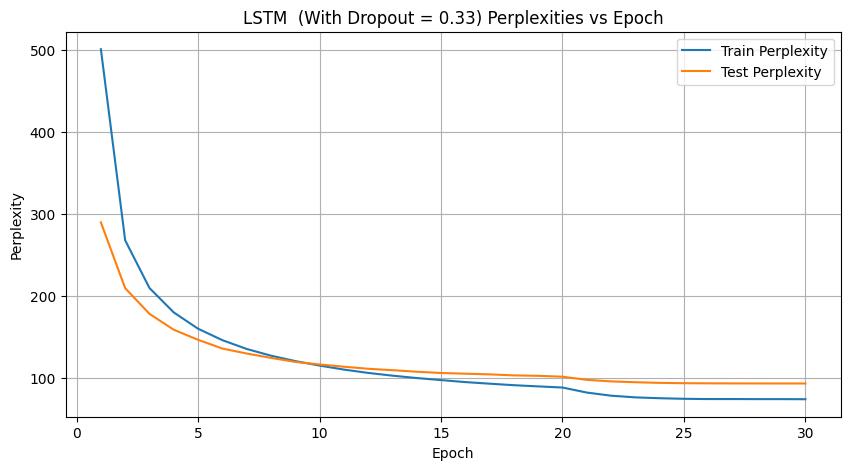

Final Train Perplexity: 74.4793
Final Test Perplexity: 93.6564
Final Validation Perplexity: 97.2535


In [43]:
DROPOUT = 0.33
LR = 6
DECAY_EPOCH = 20
MAX_EPOCH = 30


model_dropout = LSTMModel(VOCAB_SIZE, RNN_SIZE, LAYERS, DROPOUT).to(device)
optimizer = optim.SGD(model_dropout.parameters(), lr=LR)
criterion = nn.CrossEntropyLoss()

train_perplexity_do, val_perplexity_do, test_perplexity_do = train_and_evaluate (
    model_dropout, train_data, valid_data, test_data, optimizer, criterion,
    SEQ_LENGTH, MAX_EPOCH, DECAY_EPOCH, "lstm_model_dropout.pth", "LSTM  (With Dropout = " + str(DROPOUT) + ") Perplexities vs Epoch"
)

print(f"Final Train Perplexity: {train_perplexity_do:.4f}")
print(f"Final Test Perplexity: {test_perplexity_do:.4f}")
print(f"Final Validation Perplexity: {val_perplexity_do:.4f}")

### OPTIONAL: **Infer With Trained Model** (example)

In [ ]:
model = LSTMModel(VOCAB_SIZE, RNN_SIZE, LAYERS, DROPOUT).to(device)

model.load_state_dict(torch.load("lstm_model_dropout.pth"))
model.eval()

def predict(model, data):
    model.eval()
    with torch.no_grad():
        output = model(data)
    return output


Example inference


```
test_input = torch.tensor([your_test_sequence], dtype=torch.long)  # Replace with actual test data
output = predict(model, test_input)
print(f"Inference result: {output}")
```



# Gated Recurrent Units (**GRU**) Model (Pytorch nn.Module)

In [44]:
class GRUModel(nn.Module):
    def __init__(self, vocab_size, rnn_size, layers, dropout):
        super(GRUModel, self).__init__()
        self.drop = nn.Dropout(dropout)
        self.encoder = nn.Embedding(vocab_size, rnn_size)
        self.gru = nn.GRU(rnn_size, rnn_size, layers, dropout=dropout)
        self.decoder = nn.Linear(rnn_size, vocab_size)
        self.init_weights()
        self.rnn_size = rnn_size
        self.layers = layers

    def init_weights(self):
        initrange = INIT_WEIGHT
        self.encoder.weight.data.uniform_(-initrange, initrange)
        self.decoder.weight.data.uniform_(-initrange, initrange)
        self.decoder.bias.data.zero_()

    def forward(self, input, hidden):
        emb = self.drop(self.encoder(input))
        output, hidden = self.gru(emb, hidden)
        output = self.drop(output)
        decoded = self.decoder(output.view(output.size(0) * output.size(1), output.size(2)))
        return decoded.view(output.size(0), output.size(1), decoded.size(1)), hidden

    def init_hidden(self, bsize):
        weight = next(self.parameters())
        return weight.new_zeros(LAYERS, bsize, RNN_SIZE)

#GRU (no dropout) Evaluation

#### Evaluated on word-level perplexity as a function of training epoch

##### PARAMETERS


1.   **Dropout = 0.00 %**
2.   **Learning Rate = 1**
3.   **Learning Rate Decay Epoch = 7**
4.   **Number of Epochs = 13**



Epoch 1, Train Perplexity: 467.0855, Val Perplexity: 294.7341, Test Perplexity: 286.8951
Epoch 2, Train Perplexity: 234.0869, Val Perplexity: 216.1602, Test Perplexity: 211.0104
Epoch 3, Train Perplexity: 175.8325, Val Perplexity: 182.7195, Test Perplexity: 178.5707
Epoch 4, Train Perplexity: 145.3017, Val Perplexity: 163.6984, Test Perplexity: 160.6749
Epoch 5, Train Perplexity: 125.3247, Val Perplexity: 152.1348, Test Perplexity: 149.6087
Epoch 6, Train Perplexity: 110.8362, Val Perplexity: 143.9814, Test Perplexity: 141.6406
Epoch 7, Train Perplexity: 99.6262, Val Perplexity: 138.9685, Test Perplexity: 136.8356
Learning rate reduced to: 0.5000
Epoch 8, Train Perplexity: 86.4569, Val Perplexity: 130.9649, Test Perplexity: 128.3758
Learning rate reduced to: 0.2500
Epoch 9, Train Perplexity: 80.0604, Val Perplexity: 126.4121, Test Perplexity: 123.5648
Learning rate reduced to: 0.1250
Epoch 10, Train Perplexity: 76.8466, Val Perplexity: 124.3807, Test Perplexity: 121.4226
Learning rate 

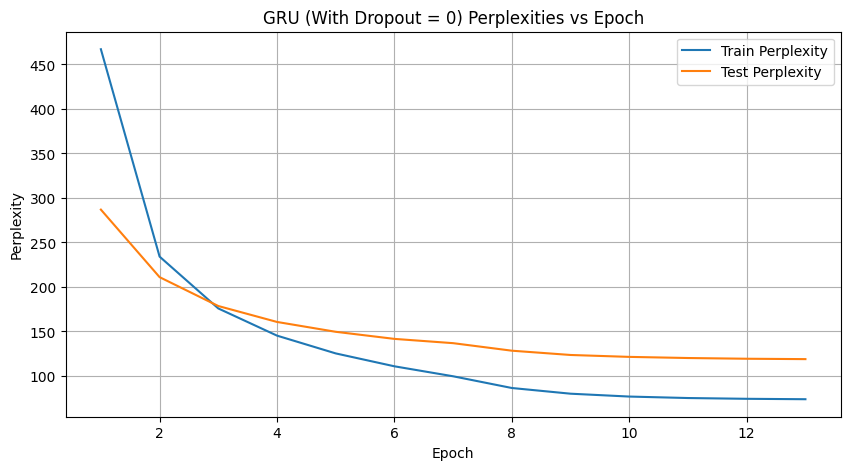

Final Train Perplexity: 73.8554
Final Test Perplexity: 118.9037
Final Validation Perplexity: 122.1354


In [46]:
DROPOUT = 0
LR = 1
DECAY_EPOCH = 7
MAX_EPOCH = 13

model_gru_no_drop = GRUModel(VOCAB_SIZE, RNN_SIZE, LAYERS, DROPOUT).to(device)
optimizer = optim.SGD(model_gru_no_drop.parameters(), lr=LR)
criterion = nn.CrossEntropyLoss()

train_perplexity_gru, val_perplexity_gru, test_perplexity_gru = train_and_evaluate(
    model_gru_no_drop, train_data, valid_data, test_data, optimizer, criterion,
    SEQ_LENGTH, MAX_EPOCH, DECAY_EPOCH, "gru_model.pth", "GRU (With Dropout = " + str(DROPOUT) + ") Perplexities vs Epoch"
)

print(f"Final Train Perplexity: {train_perplexity_gru:.4f}")
print(f"Final Test Perplexity: {test_perplexity_gru:.4f}")
print(f"Final Validation Perplexity: {val_perplexity_gru:.4f}")

### OPTIONAL: **Infer With Trained Model** (example)

In [ ]:
model = GRUModel(VOCAB_SIZE, RNN_SIZE, LAYERS, DROPOUT).to(device)

model.load_state_dict(torch.load("gru_model.pth.pth"))
model.eval()

def predict(model, data):
    model.eval()
    with torch.no_grad():
        output = model(data)
    return output


Example inference


```
test_input = torch.tensor([your_test_sequence], dtype=torch.long)  # Replace with actual test data
output = predict(model, test_input)
print(f"Inference result: {output}")
```



#GRU *With Dropout*  Evaluation

#### Evaluated on word-level perplexity as a function of training epoch

##### PARAMETERS


1.   **Dropout = 0.00 %**
2.   **Learning Rate = 1**
3.   **Learning Rate Decay Epoch = 7**
4.   **Number of Epochs = 13**



Epoch 1, Train Perplexity: 415.5957, Val Perplexity: 256.2069, Test Perplexity: 252.0454
Epoch 2, Train Perplexity: 226.2987, Val Perplexity: 195.6320, Test Perplexity: 190.6981
Epoch 3, Train Perplexity: 179.9195, Val Perplexity: 166.8189, Test Perplexity: 163.7056
Epoch 4, Train Perplexity: 154.9989, Val Perplexity: 151.9715, Test Perplexity: 149.7428
Epoch 5, Train Perplexity: 139.0681, Val Perplexity: 142.0985, Test Perplexity: 140.0905
Epoch 6, Train Perplexity: 127.8140, Val Perplexity: 134.6771, Test Perplexity: 132.6309
Epoch 7, Train Perplexity: 119.1016, Val Perplexity: 131.1095, Test Perplexity: 129.1113
Epoch 8, Train Perplexity: 112.4140, Val Perplexity: 128.2617, Test Perplexity: 125.4135
Epoch 9, Train Perplexity: 107.1734, Val Perplexity: 125.2635, Test Perplexity: 122.5046
Epoch 10, Train Perplexity: 102.7578, Val Perplexity: 122.8096, Test Perplexity: 120.3995
Epoch 11, Train Perplexity: 98.9855, Val Perplexity: 122.4361, Test Perplexity: 119.8596
Epoch 12, Train Perp

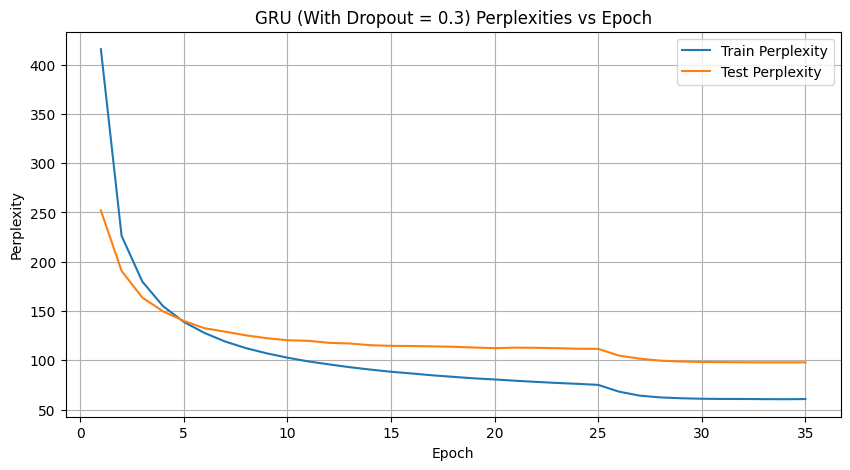

In [49]:
DROPOUT = 0.30
LR = 2
DECAY_EPOCH = 25
MAX_EPOCH = 35

model_gru_drop = GRUModel(VOCAB_SIZE, RNN_SIZE, LAYERS, DROPOUT).to(device)
optimizer = optim.SGD(model_gru_drop.parameters(), lr=LR)
criterion = nn.CrossEntropyLoss()

train_perplexity_gru, val_perplexity_gru, test_perplexity_gru = train_and_evaluate(
    model_gru_drop, train_data, valid_data, test_data, optimizer, criterion,
    SEQ_LENGTH, MAX_EPOCH, DECAY_EPOCH, "gru_model_dropout.pth", "GRU (With Dropout = " + str(DROPOUT) + ") Perplexities vs Epoch"
)

### OPTIONAL: **Infer With Trained Model** (example)

In [ ]:
model = GRUModel(VOCAB_SIZE, RNN_SIZE, LAYERS, DROPOUT).to(device)

model.load_state_dict(torch.load("gru_model_dropout.pth.pth"))
model.eval()

def predict(model, data):
    model.eval()
    with torch.no_grad():
        output = model(data)
    return output


Example inference


```
test_input = torch.tensor([your_test_sequence], dtype=torch.long)  # Replace with actual test data
output = predict(model, test_input)
print(f"Inference result: {output}")
```

